# Intro to polysomnogram classification using movement, heart rate and step count data collected from Apple Watches


As part of our final year studying data science, we have been tasked with classifying polysomnogram (PSG) status by using data collected from an Apple Watch. The data used was from [this study](https://physionet.org/content/sleep-accel/1.0.0/), where there were 31 participants.  

--- 
PSG status was recorded every 30 seconds in the study.  
We began by preparing our data and creating heart rate, step count and x, y and z movement entries at 1 second intervals for each subject.  

---
We then passed this data to our feature extraction notebook, where we used the tsfresh feature extraction module. We gave each 30 second interval a unique session id whereby features would be extracted to represent each particular session for each subject.  
We also used feature selection to reduce the feature space.  
We then grouped the features formed from each session by PSG status. This gave us a set of features which represented each PSG status.  

---  
We then passed these features to our classification notebook. Here we read in data representing our approach of keeping sleep status, filtering the feature space.  
We chose to try 3 classification algorithms, SVM Classifier, K neighbours and Decision Tree, to get a full perspective on how well each subject's data could be classified.  

---
To conclude, we tested the decisions that we made throughout the project.
1. Was it a good decision to filter the features?  
2. Was it a good decision to include the test data?
3. Was it a good decision to use parameter optimisation?

We also tried autoML and binary labels representing sleep / awake to see could we get even better results if this was the case.

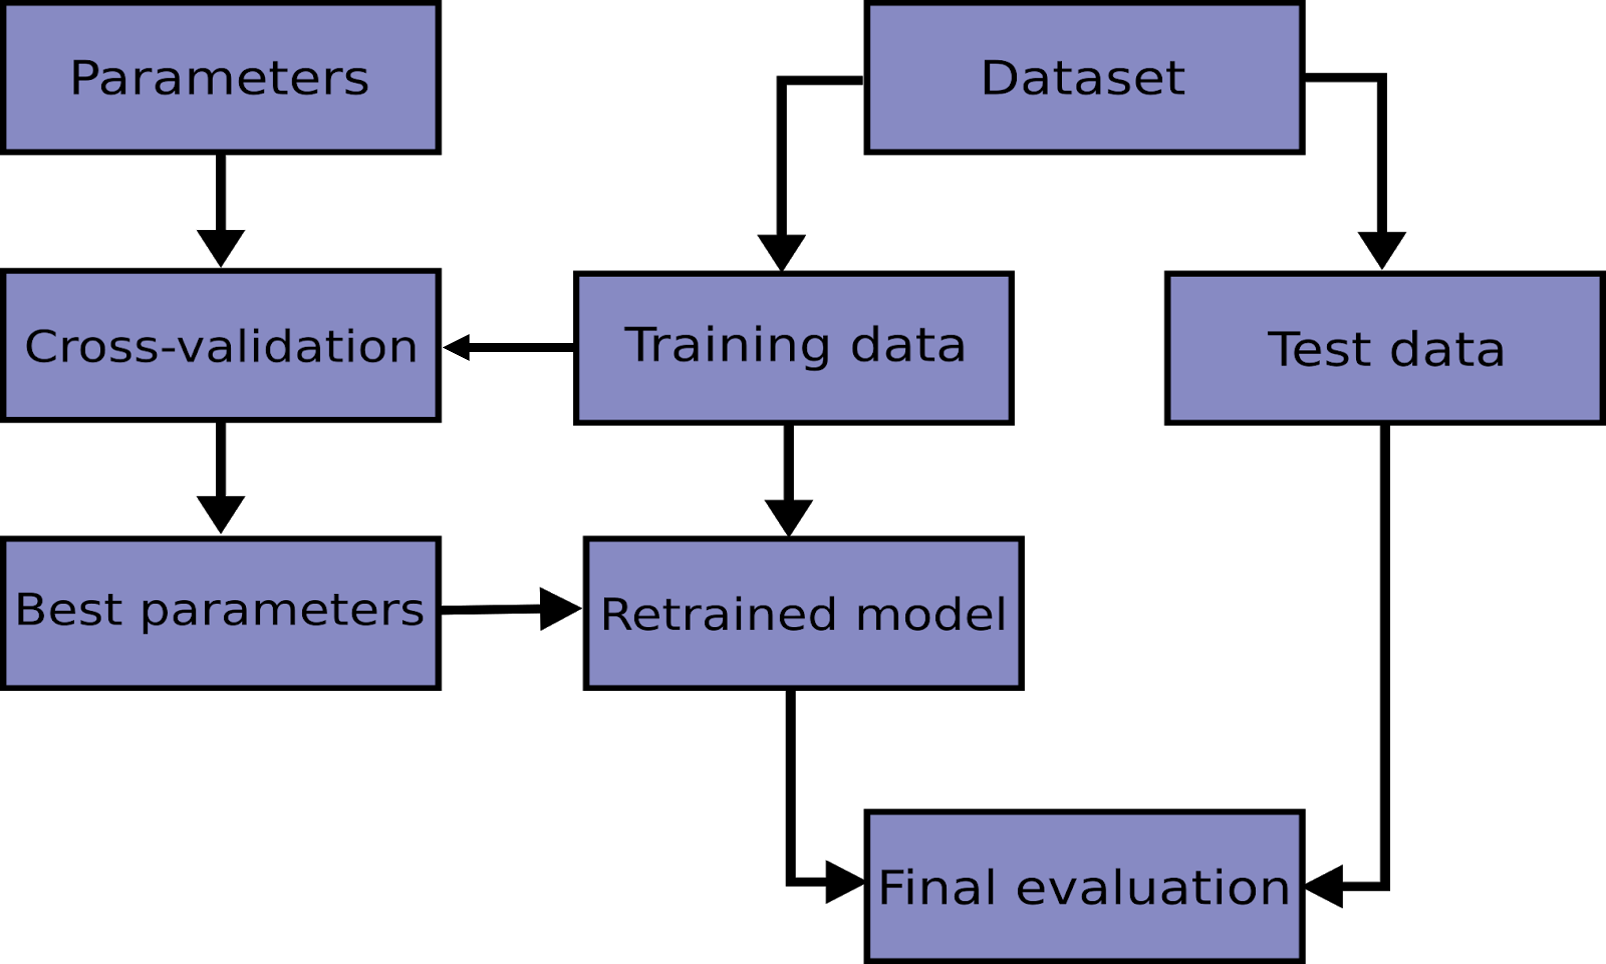

---
---

# 1. Setup

---
---

### Import Packages

##### Import general packages

In [ ]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

##### Import & setup the Json package for exporting the data to a Json file

In [ ]:
import json

class JSONEncoder(json.JSONEncoder):
    def default(self, obj):
        if hasattr(obj, 'to_json'):
            return obj.to_json(orient='records')
        return json.JSONEncoder.default(self, obj)

### Mount the drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Set the directory for reading the data

In [ ]:
os.chdir('/content/drive/My Drive/4th Year/CA4015/assignment2/Submission/data')    # Ivan's directory
# os.chdir('/content/drive/My Drive/assignment2/Submission/data')                     # Nathan's directory

### Set the maximum number of rows and columns seen in the output

In [ ]:
pd.set_option('max_rows', 25)
pd.set_option('max_columns', 25)

---
---

# 2. Read in the data

---
---

There are four different sensors for each subject that record a time and a sensor reading. The data from these sensors for each subject are stored in seperate files and need to be read in seperately so that we can then join them all into one dataframe for each subject.

*As provided by Eoin, The following types of data are provided:*

**motion (acceleration)**: Saved as txt files with the naming convention '[subject-id-number]_acceleration.txt'

Each line in this file has the format: date (in seconds since PSG start), x acceleration (in g), y acceleration, z acceleration
 
**heart rate (bpm)**: Saved as txt files with the naming convention '[subject-id-number]_heartrate.txt'

Each line in this file has the format: date (in seconds since PSG start), heart rate (bpm)
 
**steps (count)**: Recorded from the Apple Watch and saved in the format '[subject-id-number]_steps.txt'

Each line in this file has the format: date (in seconds since PSG start), steps (total in bin from this timestamp to next timestamp)
 
**labeled sleep**: Recorded from polysomnography and saved in the format '[subject-id-number]_labeled_sleep.txt'

Each line in this file has the format: date (in seconds since PSG start) stage (0-5, wake = 0, N1 = 1, N2 = 2, N3 = 3, REM = 5)


### Create a function to read in, analyse and join the different data sources

In [ ]:
def read_in_subject_data(subject_id):
    # read in motion data
    motion_df = pd.read_csv('../data/original_sensor_data_files/{}_cleaned_motion.out'.format(subject_id), sep=' ', names=["second", "x_move", "y_move", "z_move"])

    # read in heart rate data
    hr_df = pd.read_csv('../data/original_sensor_data_files/{}_cleaned_hr.out'.format(subject_id), sep=' ', names=["second", "heart_rate"])

    # read in the step count data
    steps_df = pd.read_csv('../data/original_sensor_data_files/{}_cleaned_counts.out'.format(subject_id), names=["second", "step_count"])

    # read in psg sleep status data
    psg_df = pd.read_csv('../data/original_sensor_data_files/{}_cleaned_psg.out'.format(subject_id), sep=' ', names=["second", "psg_status"])

    # clean the psg data to remove '-1' values - turn values with '-1' to 'nan'
    psg_df.replace(-1, float('nan'), inplace=True)

    return (motion_df, hr_df, steps_df, psg_df)

In [ ]:
def analyse_sensor_data(sensor_data_df):
    print("   - Starts at", round(min(sensor_data_df.second), 4), "seconds")
    print("   - Ends at", round(max(sensor_data_df.second), 4), "seconds")

    print("\n   - Collects data every", round(max(sensor_data_df.second)/len(sensor_data_df), 4), "seconds")

In [ ]:
def join_sensor_dataframes(motion_df, hr_df, steps_df, psg_df):
  
    # join the dataframes together
    motion_nd_hr_df = pd.merge(motion_df, hr_df, on="second", how="outer")
    motion_hr_nd_steps_df = pd.merge(motion_nd_hr_df, steps_df, on="second", how="outer")
    all_sensor_df = pd.merge(motion_hr_nd_steps_df, psg_df, on="second", how="outer")

    # sort df by second column
    all_sensor_df["second"] = all_sensor_df["second"].astype("float")
    all_sensor_df = all_sensor_df.sort_values("second")
    all_sensor_df = all_sensor_df.reset_index(drop=True)

    return all_sensor_df

### Get a list of all the **subject ids** from the input files

In [ ]:
subject_ids = []
for n, filename in enumerate(os.listdir('../data/original_sensor_data_files/')):
    terms = filename.split('_')
    subject_id = int(terms[0])
  
    if subject_id not in subject_ids:
        subject_ids.append(subject_id)
    
# sort the list
sorted_subject_ids = sorted(subject_ids)

print("There are", len(sorted_subject_ids), "subject id's\nThey are:\n", sorted_subject_ids)

There are 31 subject id's
They are:
 [46343, 759667, 781756, 844359, 1066528, 1360686, 1449548, 1455390, 1818471, 2598705, 2638030, 3509524, 3997827, 4018081, 4314139, 4426783, 5132496, 5383425, 5498603, 5797046, 6220552, 7749105, 8000685, 8173033, 8258170, 8530312, 8686948, 8692923, 9106476, 9618981, 9961348]


### Read in the data, analyse it and create a map of subject_id to sensor data
The print_analysis variable below can be changed to True to see an output of data for each subject.

In [ ]:
print_analysis = False

In [ ]:
map_subject_id_to_sensor_dataframes = {}
for subject_id in tqdm(sorted_subject_ids):

    # read in the data
    motion_df, hr_df, steps_df, psg_df = read_in_subject_data(subject_id)

    if print_analysis:
        # print which subject_id we are analysing
        print("\n--------------------------------------------------------------")
        print("==========================", subject_id, "==========================")
        print("--------------------------------------------------------------")

        # analyse the data using print statements
        print("The motion sensor:")
        analyse_sensor_data(motion_df)
        print("\nThe heart rate sensor:")
        analyse_sensor_data(hr_df)
        print("\nThe PSG study data:")
        analyse_sensor_data(psg_df)
        print("\nThe step count sensor:")
        analyse_sensor_data(steps_df)

    # join these sensor dataframes together
    all_sensor_df = join_sensor_dataframes(motion_df, hr_df, steps_df, psg_df)

    # add this subject to the map - map it to its sensor dataframe
    map_subject_id_to_sensor_dataframes[subject_id] = all_sensor_df

---
---

# 3. Fix the dataframe so that the seconds column is at a fixed interval

---
---

### Define the functions to normalise the second values

In [ ]:
def where_no_sensor_value_has_been_recorded_up_till_that_second_turn_this_to_a_val(df, val):

    fixed_df = df.copy()
    # iterate through these columns and fix the 'Nan' values
    for col in fixed_df.drop(columns=["second"], axis=1):

        # iterate backwards over rows and turn "Nan" boxes to the specified val and find where the "Nan" values stop
        i = len(fixed_df[col]) - 1
        while np.isnan(fixed_df[col][i]):
            fixed_df[col][i] = val
            i = i - 1

        # iterate forwards over rows and turn "Nan" boxes to the specified val and find where real values start
        j = 0
        while np.isnan(fixed_df[col][j]):
            fixed_df[col][j] = val
            j = j + 1

    return fixed_df

In [ ]:
def fill_in_the_dfs_nan_values(df):

    # fill the "Nan" values with the value encountered before the "Nan" up until it hits the point where the rest of that column is only "Nan" values
    filled_df = df.fillna(method="ffill")

    # fill the "Nan" values with an interpolated value using the value before this "Nan" value and after this "Nan" value
    # filled_df = df.interpolate()

    return filled_df

In [ ]:
def get_list_of_averages_for_each_col_of_all_rows(rows, val_to_fill_nans, cols_no_second_list):

    # if there are no values between the specified seconds
    if len(rows) == 0:
        # add empty row
        list_of_averages = list(np.repeat(float("nan"), len(cols_no_second_list)))

    # if there is at least one row with a value between these seconds
    elif len(rows) > 0:
        # average the values in these rows to get just 1 row with the values for each column
        list_of_averages = []
        for col in cols_no_second_list:

            # make sure that the sleep labels column only contains whole numbers - they must maintain their classification label
            if col == 'psg_status':
                # count the number of occurances of each value and take the one that occurs most as this value
                avg = float(rows.loc[:, col].mode()[0])
                    
            # first check if the values are all valid values - replace "Nan" with a value so these are invalid
            elif set(rows.loc[:, col]) != {val_to_fill_nans} and val_to_fill_nans in list(rows.loc[:, col]):
                count_nans = 0
                non_nan_vals = []

                # iterate through these row values to count how many invalid(-10) values there are
                for v in rows.loc[:, col]:
                    if v == val_to_fill_nans:
                        count_nans += 1
                      
                    else:
                        count_nans -= 1
                        non_nan_vals.append(v)

                # if there are more invalid rows than there are proper ones
                if count_nans > 0:
                    avg = sum(non_nan_vals)/len(non_nan_vals)

                # if there are more proper values than invalid ones
                elif count_nans < 0:
                    avg = val_to_fill_nans

                # if there is the exact same amout of invalid values and proper values, use the most common single value or the first of these most common values
                else:
                    print(rows)
                    avg = float(rows.loc[:, col].mode()[0])

            # if all the values are proper values, then just get the means of these values and populate the row with this
            else:
                avg = rows.loc[:, col].mean()
                
            list_of_averages.append(avg)

    return list_of_averages

In [ ]:
def turn_seconds_to_a_set_interval(filled_sensor_df, second_column_step, val_to_fill_nans):

    # define a variable for the second column
    sec_col = filled_sensor_df.second

    # get a ist of the cols exluding the second column
    cols_no_second_list = filled_sensor_df.drop(columns=["second"], axis=1).columns

    # get the value of the maximum and minimum second in this dataframe
    min_second_in_df = int(round(min(sec_col) - 0.5))
    max_second_in_df = int(round(max(sec_col) + 0.5))

    # create a new dataframe that we will populate
    new_df = pd.DataFrame(columns=(filled_sensor_df.columns))

    # iterate through each second interval in this dataframe
    for i in tqdm(np.arange(min_second_in_df, max_second_in_df + second_column_step, second_column_step)):

        # get the rows between second "i - 1" and second "i"
        rows = filled_sensor_df.loc[(sec_col > i - (second_column_step - 0.00000001)) & (sec_col < i + 0.00000001)]
        rows = rows.reset_index(drop=True)
        
        list_of_averages = get_list_of_averages_for_each_col_of_all_rows(rows, val_to_fill_nans, cols_no_second_list)

        # create a dataframe row from this list
        new_df_row = pd.DataFrame([i] + list_of_averages, columns=[i], index=filled_sensor_df.columns).T

        # add this row to the new DataFrame
        new_df = pd.concat([new_df, new_df_row], axis=0)

    return new_df

In [ ]:
def is_not_nan(v):
  return v == v

### Iterate through the map we created to normalise the second data
The second_column_step vairable below can be adjusted to a custom time interval

This cell take a long time to run!

In [ ]:
val_to_fill_nans = -100
second_column_step = 1

In [ ]:
map_subject_id_to_joined_and_uniform_second_sensor_df = {}
for subject_id, all_sensors_df in tqdm(map_subject_id_to_sensor_dataframes.items()):

    # print the subject_id
    print("\t\t", subject_id)

    # set values where there was no sensor value taken to be a value instead of 'Nan'
    half_filled_df = where_no_sensor_value_has_been_recorded_up_till_that_second_turn_this_to_a_val(all_sensors_df, val_to_fill_nans)

    # fill the Nan values in the dataframe
    filled_sensor_df = fill_in_the_dfs_nan_values(half_filled_df)

    # replace the "-10" values with "Nan" values
    df_val_to_fill_nan_replaced = filled_sensor_df.replace(val_to_fill_nans, float("nan"))

    # drop the rows that have an 'Nan' value for any of the sensors - this means that the sensor hadn't recorded it's first value yet
    no_nan_values = df_val_to_fill_nan_replaced.dropna()

    # turn the second column to a uniform interval by averaging the other columns
    uniform_second_interval_df = turn_seconds_to_a_set_interval(no_nan_values, second_column_step, val_to_fill_nans)

    # fill the nan values in the dataframe
    df_with_one_sec_per_row = fill_in_the_dfs_nan_values(uniform_second_interval_df)

    # reset the index
    df_with_one_sec_per_row.reset_index(drop=True, inplace=True)

    # clean out the rows where there is an invalid sleep state value
    remove_invalid_sleep_state = df_with_one_sec_per_row[is_not_nan(df_with_one_sec_per_row["psg_status"])]
    remove_invalid_sleep_state.reset_index(drop=True, inplace=True)

    # create a new map of the subject_id to this new dataframe
    map_subject_id_to_joined_and_uniform_second_sensor_df[subject_id] = remove_invalid_sleep_state

		 46343



		 759667



		 781756



		 844359



		 1066528



		 1360686



		 1449548



		 1455390



		 1818471



		 2598705



		 2638030



		 3509524



		 3997827



		 4018081



		 4314139



		 4426783



		 5132496



		 5383425



		 5498603



		 5797046



		 6220552



		 7749105



		 8000685



		 8173033



		 8258170



		 8530312



		 8686948



		 8692923



		 9106476



		 9618981



		 9961348


### Have a look at this created dictionary

In [ ]:
i = 0
for student_id, df in map_subject_id_to_joined_and_uniform_second_sensor_df.items():
    print("--------------------", student_id, "--------------------")
    print(df)

    if i == 3:
        break
    i = i + 1

-------------------- 46343 --------------------
        second    x_move    y_move    z_move  heart_rate  step_count  \
0        390.0 -0.540527  0.680496 -0.271774        90.0   79.820000   
1        391.0 -0.426881  0.920799 -0.093921        90.0  109.617059   
2        392.0 -0.448256  0.816442 -0.228871        90.0  125.870000   
3        393.0 -0.464479  0.765035 -0.432477        90.0  125.870000   
4        394.0 -0.494360  0.798880 -0.076882        90.0  125.870000   
...        ...       ...       ...       ...         ...         ...   
16556  16946.0 -0.441763 -0.525671  0.723509        73.0    0.000000   
16557  16947.0 -0.441267 -0.525272  0.724310        73.0    0.000000   
16558  16948.0 -0.441876 -0.525352  0.724083        73.0    0.000000   
16559  16949.0 -0.442227 -0.525543  0.723603        73.0    0.000000   
16560  16950.0 -0.441905 -0.525534  0.723882        73.0    0.000000   

       psg_status  
0             0.0  
1             0.0  
2             0.0  
3      

---
---

# 4. Store this dictionary in a json file

---
---

In [ ]:
# put the dataframe in the json file
with open('map_of_subject_id_to_its_cleaned_sensor_data.json', 'w') as fp:
    json.dump(map_subject_id_to_joined_and_uniform_second_sensor_df, fp, cls=JSONEncoder)

In [ ]:
# make a copy with no steps - for further analysis later on
# for student_id, df in map_subject_id_to_joined_and_uniform_second_sensor_df.items():
#   print(df.drop(['step_count'], axis=1))
# put the dataframe in the json file
# with open('no_step_map_of_subject_id_to_its cleaned_sensor_data.json', 'w') as fp:
#     json.dump(map_subject_id_to_joined_and_uniform_second_sensor_df, fp, cls=JSONEncoder)

        second    x_move    y_move    z_move  heart_rate  step_count  \
0        390.0 -0.540527  0.680496 -0.271774        90.0   79.820000   
1        391.0 -0.426881  0.920799 -0.093921        90.0  109.617059   
2        392.0 -0.448256  0.816442 -0.228871        90.0  125.870000   
3        393.0 -0.464479  0.765035 -0.432477        90.0  125.870000   
4        394.0 -0.494360  0.798880 -0.076882        90.0  125.870000   
...        ...       ...       ...       ...         ...         ...   
16556  16946.0 -0.441763 -0.525671  0.723509        73.0    0.000000   
16557  16947.0 -0.441267 -0.525272  0.724310        73.0    0.000000   
16558  16948.0 -0.441876 -0.525352  0.724083        73.0    0.000000   
16559  16949.0 -0.442227 -0.525543  0.723603        73.0    0.000000   
16560  16950.0 -0.441905 -0.525534  0.723882        73.0    0.000000   

       psg_status  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
...           .